In [ ]:
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
import tensorflow_hub as hub
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

#import tensorflow_hub as hub
import os
import json
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import mobilenet_v2, inception_v3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!git clone https://gitlab.com/huix/leaf-disease-plant-village.git

Cloning into 'leaf-disease-plant-village'...
remote: Enumerating objects: 58332, done.
remote: Counting objects: 100% (58332/58332), done.
remote: Compressing objects: 100% (58308/58308), done.
remote: Total 58332 (delta 108), reused 58176 (delta 20), pack-reused 0
Receiving objects: 100% (58332/58332), 829.84 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Checking out files: 100% (58221/58221), done.


**Dataset:- plant_village**

[Tensorflow dataset link](https://https://www.tensorflow.org/datasets/catalog/plant_village)



In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub Version:",hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
Hub Version: 0.8.0
GPU is available


In [ ]:
data_dir=os.path.join(os.getcwd(),'/content/leaf-disease-plant-village/plantvillage_deeplearning_paper_dataset/')
image_dir=os.path.join(data_dir,'color')

In [ ]:
#use (224, 224) for Mobilenet, or (299, 299) for inception

IMAGE_SIZE = (224, 224) #@param ["(224, 224)", "(299, 299)"] {type:"raw", allow-input: true}
BATCH_SIZE = 64 #@param {type:"integer"}

In [ ]:

# augment = True #@param {type:"boolean"}
# if augment:
#   training_datagen = ImageDataGenerator(
#       rescale = 1./255,
#       rotation_range=40,
#       horizontal_flip=True,
#       width_shift_range=0.2, 
#       height_shift_range=0.2,
#       shear_range=0.2, 
#       zoom_range=0.2,
#       validation_split=0.2,
#       fill_mode='nearest' )
# else:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

training_generator = datagen.flow_from_directory(image_dir,
                                                 shuffle=False,
                                                 seed=42,
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 subset="training",
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE)

validation_generator = datagen.flow_from_directory(
    image_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


**ADDING AUGMENTATION**

In [ ]:
# model=tf.keras.applications.InceptionResNetV2(
#     include_top=True, weights='imagenet', input_tensor=None, input_shape=(299,299,3),
#     pooling=None, classes=1000, classifier_activation='softmax')

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(training_generator.num_classes, activation='softmax')
])

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        training_generator,
        steps_per_epoch=training_generator.samples//training_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
679/679 [==============================] - 156s 229ms/step - loss: 1.9432 - accuracy: 0.5227 - val_loss: 0.7010 - val_accuracy: 0.7898
Epoch 2/10
679/679 [==============================] - 155s 228ms/step - loss: 0.7209 - accuracy: 0.7769 - val_loss: 0.4448 - val_accuracy: 0.8655
Epoch 3/10
679/679 [==============================] - 153s 225ms/step - loss: 0.5111 - accuracy: 0.8332 - val_loss: 0.3286 - val_accuracy: 0.8902
Epoch 4/10
679/679 [==============================] - 153s 226ms/step - loss: 0.4269 - accuracy: 0.8579 - val_loss: 0.2668 - val_accuracy: 0.9099
Epoch 5/10
679/679 [==============================] - 151s 223ms/step - loss: 0.3608 - accuracy: 0.8809 - val_loss: 0.2981 - val_accuracy: 0.8965
Epoch 6/10
679/679 [==============================] - 148s 218ms/step - loss: 0.3398 - accuracy: 0.8864 - val_loss: 0.2230 - val_accuracy: 0.9243
Epoch 7/10
679/679 [==============================] - 152s 224ms/step - loss: 0.3124 - accuracy: 0.8952 - val_loss: 0.2209 -

**Model if trained with accuracy of 93.33%**

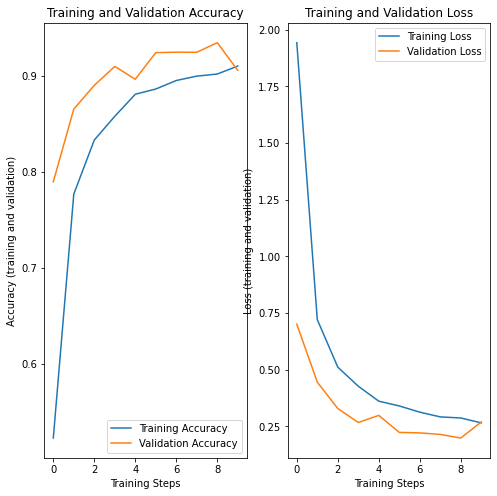

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
import json

with open(os.path.join(data_dir,'categories.json'), 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
model.save("model.h5")

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob

def load_image(filename):
    #img = cv2.imread(filename)
    img = cv2.imread(os.path.join(image_dir, filename)) #<-- use in case of test through existing validation dataset
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
#   img = image.load_img(path, target_size=(224, 224))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(fn)
#   print(classes)
  img= load_image(path)
  result= predict(img)
  print(result)

Saving orange1.jpg to orange1.jpg
Saving corn2.jpg to corn2.jpg
Saving corn1.jpg to corn1.jpg
Saving apple4.jpg to apple4.jpg
Saving apple3.jpg to apple3.jpg
Saving apple2.jpg to apple2 (2).jpg
Saving apple1.jpg to apple1.jpg
{'Orange___Haunglongbing_(Citrus_greening)': 1.0}
{'Corn_(maize)___Northern_Leaf_Blight': 0.56850964}
{'Corn_(maize)___healthy': 0.7359416}
{'Tomato___Spider_mites Two-spotted_spider_mite': 0.96939486}
{'Apple___healthy': 0.9883025}
{'Orange___Haunglongbing_(Citrus_greening)': 0.8219471}
{'Apple___healthy': 0.97968334}


{'Apple___Apple_scab': 0.9722463}


In [ ]:
# f=open('categories.json','r')
# cat=json.load(f)
# diseases = list(cat.values())
# idx=np.argmax(classes[0])
# print(idx)
# print(diseases[idx])

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Reloading model

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model,export_path,save_format='h5')

In [ ]:
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Orange___Haunglongbing_Citrus_greening, file: Orange___Haunglongbing_Citrus_greening/0548c34d-05ee-4416-a814-4eb74db17c77___UF.Citrus_HLB_Lab 1686.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.819752


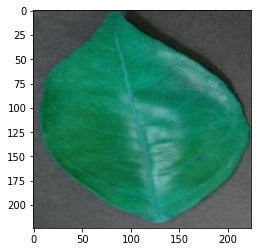

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/1af287e6-9d1e-4501-a113-d1a2b7c54b62___YLCV_GCREC 5321.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.999894


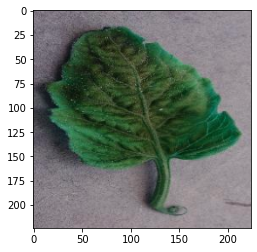

SOURCE: class: Pepper_bell___healthy, file: Pepper_bell___healthy/1a93f310-cd75-4af6-96d3-690180b4542a___JR_HL 5850.JPG
PREDICTED: class: Pepper,_bell___healthy, confidence: 0.999641


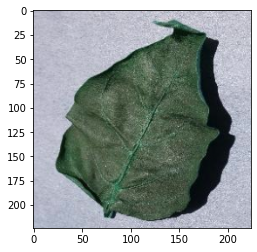

<Figure size 432x288 with 0 Axes>

SOURCE: class: Apple___healthy, file: Apple___healthy/1331fd38-acdf-488f-a5db-8dfcecfa5690___RS_HL 7381.JPG
PREDICTED: class: Apple___healthy, confidence: 0.992797


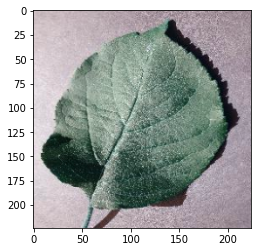

<Figure size 432x288 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_Citrus_greening, file: Orange___Haunglongbing_Citrus_greening/173bd3c0-37d8-4cc3-ae61-7a4f4cbbd993___UF.Citrus_HLB_Lab 0957.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.999967


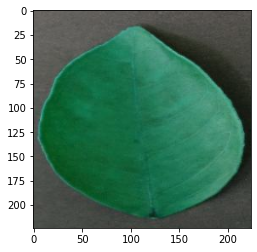

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Late_blight, file: Tomato___Late_blight/259d42ea-6860-4a01-82e5-2a81c75892b7___RS_Late.B 5112.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.293656


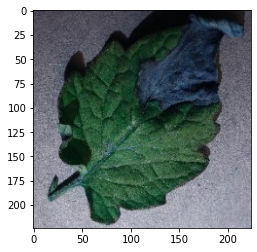

<Figure size 432x288 with 0 Axes>

SOURCE: class: Apple___healthy, file: Apple___healthy/18873cb4-cf30-414d-9ffd-c965879d84b1___RS_HL 6239.JPG
PREDICTED: class: Apple___healthy, confidence: 0.987815


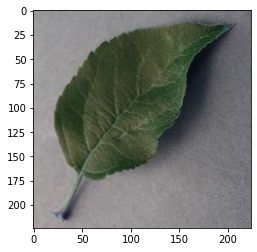

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 7)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()